# Coursework: Optimisation of a fantasy football team

The coursework is described in detail in the documentation provided on Moodle. This notebook contains some code for basic functions that read in the data file and define the solution/constraint checker that you must use to check your final solution.

As noted in the coursework, you don't have to use Python or DEAP to tackle this. However, the practicals have covered a lot of functionality that will be useful so you should find that the DEAP libraries provide a quick way to start and will save you some time in writing code.

## Important Information

If you use another language, then you should write out your solution to a csv file as a comma separated list of 0,1s (one value per row) indicating which players are included and then will  need to read it back to use the checker function, You report should include the screenshot of the  output from the function provided in this notebook, and *not* your own version of the function



In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

def read_file_from_directory(directory,filename):
    directory=Path(directory)
    file_path=directory/filename
    if not file_path.exists():raise FileNotFoundError(f"File not found: {file_path}")
    if not file_path.exists():raise FileNotFoundError(f"CSV file not found: {file_path}")
    return pd.read_csv(file_path).reset_index(drop=True)
    return content

# Data
The code below reads in the datafile and calculates the number of players available.  
Change the filepath to your local drive.

The file is sorted by player type. As I may check your solution **DO NOT** sort the file or alter it in any way as my code will expect to see it in this format.

Feel free to browse the file and analyse the data in any way you think might be useful

In [2]:
dir_path="."
file_name="clean-data.csv"
try:data=read_file_from_directory(dir_path,file_name)
except Exception as e:print(f"Error: {e}")
num_players=len(data.index)
budget=100
print("num possible players is %s" % (num_players))

num possible players is 523


# Helpful data
The code below extracts some useful information from the data that will be useful to you when writing your program. In particular:

- a list containing the **points** per player:  e.g. points[i] refers to the **points** associated with player *i*
- a list containing the **cost** per player: e.g. cost[i] refers to the **cost** associated with player *i*
- a list **gk** which indicates which player is a *goal-keeper*. The list is the same length as the number of players. gk[i]=0 if player *i* is not a goal-keeper; gk[i]=1 if player *i* is a goal-keeper
- a list **mid** which indicates which player is a *midfielder*. The list is the same length as the number of players. mid[i]=0 if player *i* is not a mid-fielder; mid[i]=1 if player *i* is a midfielder
- a list **defe** which indicates which player is a *defender*. The list is the same length as the number of players. defe[i]=0 if player *i* is not a defender; defe[i]=1 if player *i* is a defender
- a list **stri** which indicates which player is a *striker*. The list is the same length as the number of players. stri[i]=0 if player *i* is not a striker; stri[i]=1 if player *i* is a striker

In [3]:
points=data['Points'] 
cost=data['Cost']
gk=np.zeros(num_players)
mid=np.zeros(num_players)
defe=np.zeros(num_players)
stri=np.zeros(num_players)

for i in range(num_players):
    if data['Position'][i]=='GK':gk[i]=1
    elif data['Position'][i]=='DEF':defe[i]=1
    elif data['Position'][i]=='MID':mid[i]=1
    elif data['Position'][i]=='STR':stri[i]=1 

# Solution and constraint checker function

You are free to represent an individiual in any way you wish during the search process. However, at the end of the evolutionary run, you *must* convert your solution to a list of length *num_players* in which each element is either 0 or 1. An element *i* should be set to 0 if player *i* is not included in the team, and to 1 if player *is* **is** included in the team.

You *must* call this function with your best solution and include a screen shot of the output in your report.

In [4]:
def check_constraints(individual):
    broken_constraints=0
    totalpoints=np.sum(np.multiply(points,individual))
    c1=np.sum(individual)
    if  c1 !=11:
        broken_constraints+=1
        print("Broken Constraint: Total number of players is %s" %(c1))
    c2 = np.sum(np.multiply(cost, individual)) 
    if c2 >100:
        broken_constraints+=1
        print("Broken Constraint: Cost is %s" %(c2))
    c3 = np.sum(np.multiply(gk, individual))
    if  c3 != 1:
        broken_constraints+=1
        print("Broken Constraint: Number of GOALIES is %s " %(c3))
    c4 = np.sum(np.multiply(defe,individual))
    if  c4 > 5 or c4 < 3:
        broken_constraints+=1
        print("Broken Constraint: Number of DEFENDERS is %s " %(c4))
    c5 = np.sum(np.multiply(mid,individual))
    if  c5 > 5 or c5 < 3: 
        broken_constraints+=1
        print("Broken Constraint: Number of MID is %s " %(c5))
    c6 = np.sum(np.multiply(stri,individual))
    if c6 > 3 or c6 < 1: 
        broken_constraints+=1
        print("Broken Constraint: Number of STRIKERS is %s " %(c6))
    selectedPlayers = [idx for idx, element in enumerate(individual) if element==1]
    if broken_constraints>0:print("INVALID SOLUTION")
    print(" ")
    print(" ")
    return broken_constraints, totalpoints, c2, selectedPlayers

# Example Function for Calculating Constraint Violations

An example function is provided below for checking all the constraints. Note this is not well designed!  It simply checks if a constraint is broken (yes/no) and returns the total number of broken constraints, the total cost, and the number of players. It does not take any account of the extent to which a constraint is broken (e.g. whether there are 12 players in the team, or 500 players in the team). Similarly for the budget, it just notes if it is exceeded - not by how much

To get good solutions, you will need to consider how to modify this function...

The function can be called from a custom evaluation function (example defined below called *footballEval*)

In [5]:
def solutionEvaluator(individual):
    totalpoints=np.sum(np.multiply(points,individual))
    penalty=0
    num_selected=np.sum(individual)
    if num_selected!=11:penalty+=abs(num_selected-11)*100
    total_cost=np.sum(np.multiply(cost,individual))
    if total_cost>100:penalty+=(total_cost-100)*500
    num_gk=np.sum(np.multiply(gk,individual))
    if num_gk!=1:penalty+=abs(num_gk-1)*200
    num_def=np.sum(np.multiply(defe,individual))
    if num_def<3:penalty+=(3-num_def)*150
    elif num_def>5:penalty+=(num_def-5)*150
    num_mid=np.sum(np.multiply(mid,individual))
    if num_mid<3:penalty+=(3-num_mid)*150
    elif num_mid>5:penalty+=(num_mid-5)*150
    num_str=np.sum(np.multiply(stri,individual))
    if num_str<1:penalty+=(1-num_str)*150
    elif num_str>3:penalty+=(num_str-3)*150
    return totalpoints,penalty,total_cost

# Basic EA using DEAP

This creates a basic EA (as per the early practicals) in which a solution is represented as a list of 523 bits, each with value 0 or 1 indicating the player at index *i* in the csv file is chosen or not.  It uses a simple initialisation procedure in which each bit has an equal probability of being set to 0 or 1 *(think about why this is not an efficient representation!)*


A custom evaluation function called *footballEval* is defined and registered.  The function assigns a crude penalty to solutions that break one or more constraints. It is very basic and unlikely to lead to good solutions:
- the number of broken constraints from the *SolutionEvaluator* function is multiplied by an arbitrary constant, and this value subtracted from the 'totalpoints' score
- if no constraints are broken, i.e. the solution is valid, the score will be positive (and should be maximised); if any constraint is broken, the score will be  a negative value

You will want to consider how to modify this function (in conjunction with the SolutionEvaluator) to better guide the EA towards good solutions

All parameters/choice of operators are arbitrary - consider how you might change these


In [6]:
import array
import numpy
import random
from multiprocessing.dummy import Pool as ThreadPool
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

creator.create("FitnessMax",base.Fitness,weights=(1.0,))
creator.create("Individual",list,fitness=creator.FitnessMax)

toolbox=base.Toolbox()
def sparse_bit():
    return 1 if random.random()<0.02 else 0
toolbox.register("attr_bool",sparse_bit)
toolbox.register("individual",tools.initRepeat,creator.Individual,toolbox.attr_bool,num_players)
toolbox.register("population",tools.initRepeat,list,toolbox.individual)

def footballEval(individual):
    totalpoints,penalty,teamCost=solutionEvaluator(individual)
    return (totalpoints-penalty),

def mutSwapPlayers(individual,indpb):
    ones=[i for i,v in enumerate(individual) if v==1]
    zeros=[i for i,v in enumerate(individual) if v==0]
    for i in range(len(individual)):
        if random.random()<indpb:
            if ones and zeros:
                remove=random.choice(ones)
                add=random.choice(zeros)
                individual[remove]=0
                individual[add]=1
                ones.remove(remove)
                zeros.remove(add)
                ones.append(add)
                zeros.append(remove)
    return individual,

toolbox.register("evaluate",footballEval)
toolbox.register("mate",tools.cxTwoPoint)
toolbox.register("mutate",mutSwapPlayers,indpb=0.15)
toolbox.register("select",tools.selTournament,tournsize=3)

pool=ThreadPool()
toolbox.register("map",pool.map)

def main():
    pop=toolbox.population(n=300)
    hof=tools.HallOfFame(1)
    stats=tools.Statistics(lambda ind:ind.fitness.values)
    stats.register("avg",numpy.mean)
    stats.register("std",numpy.std)
    stats.register("min",numpy.min)
    stats.register("max",numpy.max)
    pop,log=algorithms.eaSimple(pop,toolbox,cxpb=0.5,mutpb=0.2,ngen=450,stats=stats,halloffame=hof,verbose=False)
    return pop,log,hof

In [7]:
pop, log, hof = main()


best = hof[0].fitness.values[0]
max = log.select("min")

for i in range(100):
        fit = max[i]
        if fit == best:
            break        
        
print("max fitness found is %s at gen %s " % (best, i))

max fitness found is 1805.0 at gen 99 


# CHECKER

Call the code below with your best solution and include a screen shot of the output in your report

**If your code uses a representation that is different from the one in this notebook (i.e. a bitstring of length 512 where a 0/1 indicates if the player is selected for the team) then see the instruction in cell 28 below**

In [8]:
broken_constraints,totalpoints,c2,selectedPlayers=check_constraints(hof[0])
print("final cost %s"%(c2));print("final points %s"%(totalpoints));print("broken constraints %s"%(broken_constraints));print("selected players %s"%(selectedPlayers))

 
 
final cost 100.0
final points 1805
broken constraints 0
selected players [10, 12, 67, 80, 180, 185, 261, 269, 376, 382, 466]


In [9]:
num_gk=int(np.sum(np.multiply(gk,hof[0])));num_def=int(np.sum(np.multiply(defe,hof[0])));num_mid=int(np.sum(np.multiply(mid,hof[0])));num_str=int(np.sum(np.multiply(stri,hof[0])))
print("gk: %s"%(num_gk));print("def: %s"%(num_def));print("mid: %s"%(num_mid));print("str: %s"%(num_str))

gk: 1
def: 4
mid: 4
str: 2


In [10]:
import matplotlib.pyplot as plt
results=[]
best_hof=None
best_score=0
for i in range(10):
    pop,log,hof=main()
    score=hof[0].fitness.values[0]
    results.append(score)
    broken,_,_,_=check_constraints(hof[0])
    if score>best_score and broken==0:best_score=score;best_hof=hof[0][:]
    print("run %s: %s"%(i+1,score))
print("mean: %s"%(numpy.mean(results)));print("std: %s"%(numpy.std(results)));print("min: %s"%(numpy.min(results)));print("max: %s"%(numpy.max(results)))

run 1: 1898.0
run 2: 1663.0
run 3: 1796.0
run 4: 1752.0
run 5: 1704.0
run 6: 1570.0
run 7: 1811.0
run 8: 1936.0
run 9: 1659.0
run 10: 1850.0
mean: 1763.9
std: 109.89763418745646
min: 1570.0
max: 1936.0


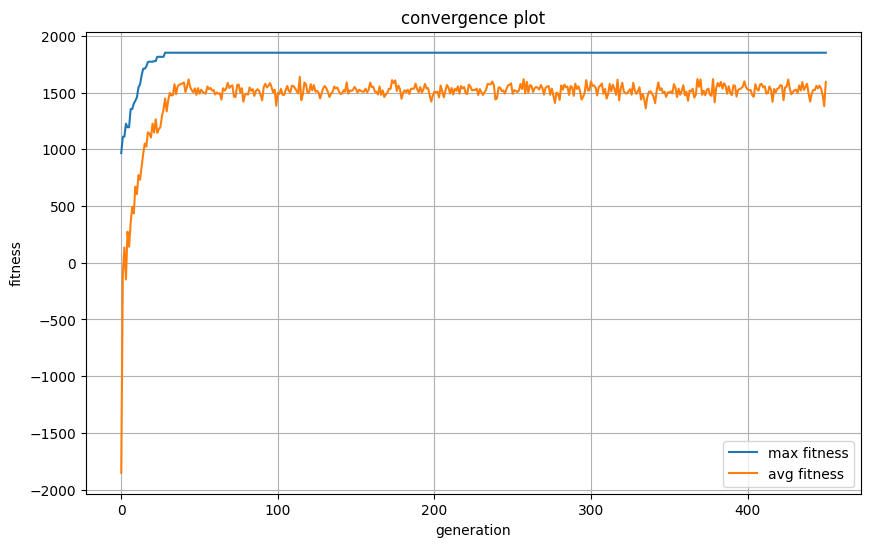

In [11]:
pop,log,hof=main()
gen=log.select("gen")
max_fit=log.select("max")
avg_fit=log.select("avg")
plt.figure(figsize=(10,6))
plt.plot(gen,max_fit,label="max fitness")
plt.plot(gen,avg_fit,label="avg fitness")
plt.xlabel("generation")
plt.ylabel("fitness")
plt.title("convergence plot")
plt.legend()
plt.grid(True)
plt.show()

rate 0.05: mean=1807.2 std=80.5354580293674
rate 0.1: mean=1755.3 std=46.24294540792141
rate 0.15: mean=1801.5 std=87.74992877489987
rate 0.2: mean=1763.3 std=60.329180335887216
rate 0.25: mean=1805.7 std=65.45998777879507


C:\Users\calum\AppData\Local\Temp\ipykernel_9624\2115285189.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results_by_rate.values(),labels=[str(r) for r in results_by_rate.keys()])


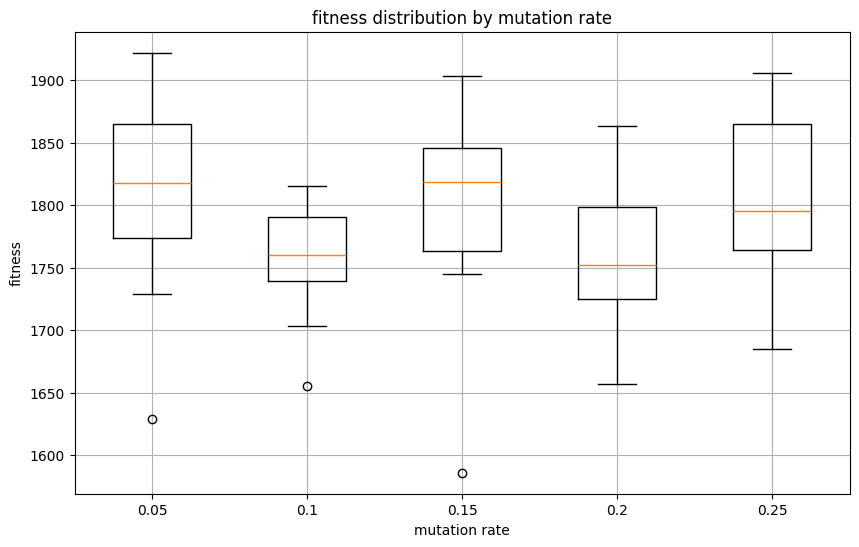

In [12]:
mutation_rates=[0.05,0.10,0.15,0.20,0.25]
results_by_rate={}
for rate in mutation_rates:
    toolbox.unregister("mutate")
    toolbox.register("mutate",mutSwapPlayers,indpb=rate)
    run_results=[]
    for i in range(10):
        pop,log,hof=main()
        run_results.append(hof[0].fitness.values[0])
    results_by_rate[rate]=run_results
    print("rate %s: mean=%s std=%s"%(rate,numpy.mean(run_results),numpy.std(run_results)))
toolbox.unregister("mutate")
toolbox.register("mutate",mutSwapPlayers,indpb=0.15)
plt.figure(figsize=(10,6))
plt.boxplot(results_by_rate.values(),labels=[str(r) for r in results_by_rate.keys()])
plt.xlabel("mutation rate")
plt.ylabel("fitness")
plt.title("fitness distribution by mutation rate")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
results=[]
best_hof=None
best_score=0
for i in range(10):
    pop,log,hof=main()
    score=hof[0].fitness.values[0]
    results.append(score)
    if score>best_score:best_score=score;best_hof=hof[0][:]
    print("run %s: %s"%(i+1,score))
print("mean: %s"%(numpy.mean(results)));print("std: %s"%(numpy.std(results)));print("min: %s"%(numpy.min(results)));print("max: %s"%(numpy.max(results)))

run 1: 1898.0
run 2: 1663.0
run 3: 1796.0
run 4: 1752.0
run 5: 1704.0
run 6: 1570.0
run 7: 1811.0
run 8: 1936.0
run 9: 1659.0
run 10: 1850.0
mean: 1763.9
std: 109.89763418745646
min: 1570.0
max: 1936.0


tournament: mean=1774.3 std=46.08047308784926
roulette: mean=1696.5 std=73.46053362180267


C:\Users\calum\AppData\Local\Temp\ipykernel_9624\2223145313.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results_by_sel.values(),labels=results_by_sel.keys())


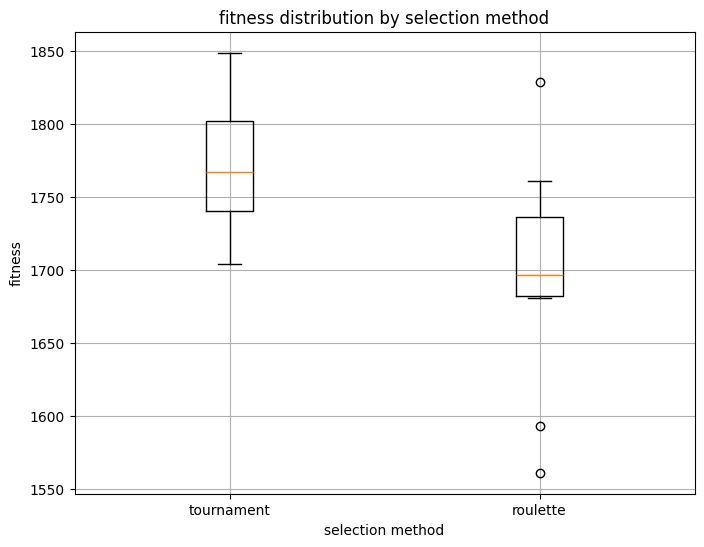

In [13]:
results_by_sel={}
toolbox.unregister("select")
toolbox.register("select",tools.selTournament,tournsize=3)
run_results=[]
for i in range(10):
    pop,log,hof=main()
    run_results.append(hof[0].fitness.values[0])
results_by_sel["tournament"]=run_results
print("tournament: mean=%s std=%s"%(numpy.mean(run_results),numpy.std(run_results)))
toolbox.unregister("select")
toolbox.register("select",tools.selRoulette)
run_results=[]
for i in range(10):
    pop,log,hof=main()
    run_results.append(hof[0].fitness.values[0])
results_by_sel["roulette"]=run_results
print("roulette: mean=%s std=%s"%(numpy.mean(run_results),numpy.std(run_results)))
toolbox.unregister("select")
toolbox.register("select",tools.selTournament,tournsize=3)
plt.figure(figsize=(8,6))
plt.boxplot(results_by_sel.values(),labels=results_by_sel.keys())
plt.xlabel("selection method")
plt.ylabel("fitness")
plt.title("fitness distribution by selection method")
plt.grid(True)
plt.show()

In [14]:
if best_hof is not None:
    broken_constraints,totalpoints,c2,selectedPlayers=check_constraints(best_hof)
    print("best solution from experiments:")
    print("final cost %s"%(c2));print("final points %s"%(totalpoints));print("broken constraints %s"%(broken_constraints));print("selected players %s"%(selectedPlayers))

Broken Constraint: Total number of players is 10
INVALID SOLUTION
 
 
best solution from experiments:
final cost 99.3
final points 2036
broken constraints 1
selected players [0, 3, 13, 180, 183, 187, 234, 376, 394, 467]


In [7]:
pop,log,hof=main()
check_constraints(hof[0])

(0,
 np.int64(1748),
 np.float64(99.5),
 [1, 21, 29, 52, 180, 183, 222, 274, 375, 376, 474])